<a id='sommaire'></a>
<h1 style='text-align:center;border:5px double;border-color:gray;'>
    <br/>
    PROJET 7<br/>
    <br/>
    "Effectuez une prédiction de revenus"
    <br/>
    <br/>
    Partie 1: Préparation des données<br/>
</h1>

## Scénario

Vous êtes employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.

Cependant, elle souhaite cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus.

L'équipe dans laquelle vous travaillez a donc reçu pour mission de créer un modèle permettant de déterminer le revenu potentiel d'une personne.

Très bien.

"Quelles informations avons-nous ?" demandez-vous à votre supérieur, qui vous répond : "À vrai dire... quasiment aucune : uniquement le revenu des parents, car nous allons cibler les enfants de nos clients actuels, ainsi que le pays où ils habitent. C'est tout ! Ah oui, une dernière chose : ce modèle doit être valable pour la plupart des pays du monde. Je vous laisse méditer là-dessus… Bon courage !"

Avec aussi peu de données disponibles, cela semble être un sacré challenge !

Ainsi, vous proposez une régression linéaire avec 3 variables :

- le revenu des parents ;
- le revenu moyen du pays dans lequel habite le prospect ;
- l'indice de Gini calculé sur les revenus des habitants du pays en question. 

## Les données
Un fichier contient les données de la World Income Distribution (fichier: WID_data.csv dans: data), daté de 2008.

Cette base de données est composée principalement d'études réalisées au niveau national pour bon nombre de pays, et contient les distributions de revenus des populations concernées.

Un fichier contenant les indices de Gini, issu de <a href="https://donnees.banquemondiale.org/indicateur/si.pov.gini?view=map">La Banque Mondiale</a>. (fichier: indices_gini.csv dans: data)

Un fichier contenant le nobre d'habitants par pays, issu de la <a href="https://donnees.banquemondiale.org/indicateur/sp.pop.totl">La Bnaque Mondiale</a> (fichier: populations.csv dans: data)

In [1]:
#! coding:utf-8
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
import os

# Style de grapique
plt.style.use('ggplot')

# Création du dossier où se trouveront les graphiques
os.makedirs('graphiques', exist_ok=True)

In [2]:
print("Pandas, version: " + pd.__version__)
print("Numpy, version: " + pd.__version__)
print("Seaborn, version: " + sns.__version__)
print("Matplotlib, version: " + matplotlib.__version__)
print("Scipy, version: " + scipy.__version__)

Pandas, version: 0.25.3
Numpy, version: 0.25.3
Seaborn, version: 0.9.0
Matplotlib, version: 3.1.2
Scipy, version: 1.4.1


<a id='m1'></a>
## Exploration des données

### Analyse des données brutes

[Haut de page](#sommaire)

In [3]:
# Chargement du fichier de la World Income Distribution
wid_brut = pd.read_csv('data/WID_data.csv', decimal=',')
wid_brut.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [4]:
wid_brut.tail()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
11594,COD,2008,96,100,810.6233,303.19305
11595,COD,2008,97,100,911.7834,303.19305
11596,COD,2008,98,100,1057.8074,303.19305
11597,COD,2008,99,100,1286.6029,303.19305
11598,COD,2008,100,100,2243.1226,303.19305


**Description des colonnes:**
- country: identifiant du pays avec 3 lettres
- year_survey: Date de l'étude qui a produit les données
- income:revenu moyen par centile
- quantile: centile correspondan
- nb_quantile: nombre de quantile (centile)
- gdpppp: Le PIB par habitant en parité de pouvoir d'achat

In [5]:
# Taille du DataFrame wid_brut
wid_brut.shape

(11599, 6)

**ATTENTION, le nombre de lignes est suspect (ce n'est pas un multiple de 100)**

In [6]:
# Vérification des valeurs manquantes
wid_brut.isnull().sum()

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64

**ATTENTION, il nous allez plus en profondeur pour 200 valeurs du gdpppp**

In [7]:
# Description par année
wid_brut.groupby(by=['year_survey']).nunique()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
year_survey,,,,,,
2004,1,1,100,1,100,1
2006,5,1,100,1,500,5
2007,15,1,100,1,1500,15
2008,76,1,100,1,7598,75
2009,12,1,100,1,1200,11
2010,6,1,100,1,600,6
2011,1,1,100,1,100,1


**La majeur partie des données date de la période entre 2007 et 2009**

In [8]:
# Chargement du fichier de correspondance Code ISO et nom du pays en anglais
code_pays = pd.read_csv("data/country_code.csv")
code_pays = code_pays[['Pays', 'ISO3']]
code_pays.head(3)

,Pays,ISO3
0,Afghanistan,AFG
1,Aland Islands,ALA
2,Albania,ALB


Le fichier de correspondance "code pays/pays" provient de <a href="http://www.trucsweb.com/tutoriels/internet/iso_3166/">trucsweb.com:</a>

In [9]:
# Jointure de wid_brut et de code_pays pour associer un pays au fichier de la Worl Income Distribution
wid = pd.merge(wid_brut, code_pays, how='left', left_on='country', right_on='ISO3')

wid.head(3)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
0,ALB,2008,1,100,728.89795,7297.0,Albania,ALB
1,ALB,2008,2,100,916.66235,7297.0,Albania,ALB
2,ALB,2008,3,100,1010.91600,7297.0,Albania,ALB


In [10]:
# Taille du DataFrame wid
wid.shape

(11599, 8)

In [11]:
# Vérification de valeurs nulles
wid.isnull().sum()

country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
Pays            100
ISO3            100
dtype: int64

**ATTENTION, La correspondance cade pays/pays n'a pas été complète**

In [12]:
# Agrégation par 'country' avec 'nunique()'
frt = wid.groupby(by='country').nunique()
frt.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
country,,,,,,,,
ALB,1,1,100,1,100,1,1,1
ARG,1,1,100,1,100,1,1,1
ARM,1,1,100,1,100,1,1,1
AUT,1,1,100,1,100,1,1,1
AZE,1,1,100,1,100,1,1,1


In [13]:
# Identification des gdpppp non renseignés
frt.loc[frt['gdpppp'] < 1]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
country,,,,,,,,
PSE,1,1,100,1,100,0,1,1
XKX,1,1,100,1,100,0,0,0


Ce sont les deux (PSE et XKX) pays qui n'ont pas le gdpppp renseigné

In [14]:
# Vérification de la quantité du nombre de quantiles
frt.loc[frt['quantile'] < 100]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
country,,,,,,,,
LTU,1,1,99,1,99,1,1,1


Ici l'explication du nombre suspect de quantile. Il manque un quantile pour LTU

In [15]:
# Vérification du nombre de quantile  par ligne
frt.loc[frt['nb_quantiles'] > 1]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
country,,,,,,,,


Tout est bon, il n'y a bien qu'un seul quantile par ligne

In [16]:
# Vérification du nombre d'année renseignée par pays
frt.loc[frt['year_survey'] > 1]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
country,,,,,,,,


Aucun pays n'a de données pour deux années différentes

In [17]:
# Vérification des valeurs manquantes dans la correspondance entre entre pays et code pays ISO
frt.loc[frt['Pays'] < 1]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
country,,,,,,,,
XKX,1,1,100,1,100,0,0,0


XKX n'a pas de correspondance dnas nos données contenant le code pays

### Correction des données

[Haut de page](#sommaire)

In [18]:
# Affectation du code ISO3-3166 Alpha-3, du nom du pays et du GDP PPP
wid.loc[wid['country'] == 'XKX', 'ISO3'] = 'XKX'
wid.loc[wid['country'] == 'XKX', 'Pays'] = 'Kosovo'
wid.loc[wid['country'] == 'XKX', 'gdpppp'] = 7530.632

wid.loc[wid['country'] == 'XKX'].head(1)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
5800,XKX,2008,1,100,437.8937,7530.632,Kosovo,XKX


Les données manquantes sont remplacées par des valeurs issues de <a href="https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD?locations=XK">La Banque Mondiale<a/>
    

In [19]:
# Affectation du GDP PPP
wid.loc[wid['country'] == 'PSE', 'gdpppp'] = 3612.14

wid.loc[wid['country'] == 'PSE'].head(1)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
11199,PSE,2009,1,100,195.2899,3612.14,Palestinian Territory Occupied,PSE


Les données manquantes sont remplacées par des valeurs issues du site <a href="https://www.theglobaleconomy.com/Palestine/GDP_per_capita_PPP/">theglobaleconomy.com</a>

In [20]:
# Affichage du GDP PPP maxi
wid.groupby('country').mean().sort_values('gdpppp').tail(3)

,year_survey,quantile,nb_quantiles,income,gdpppp
country,,,,,
NOR,2008.0,50.5,100.0,22483.375020,49070.0
LUX,2008.0,50.5,100.0,25217.562681,73127.0
FJI,2008.0,50.5,100.0,2098.730882,4300332.0


**ATENTION, la valeur du gdpppp pour FJI semble incohérente**

In [21]:
# Affectation d'une valeur de GDP PPP plus cohérente
wid.loc[wid['country'] == 'FJI', 'gdpppp'] = 7384.086
wid.loc[wid['country'] == 'FJI'].head(1)

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
3200,FJI,2008,1,100,308.17334,7384.086,Fiji,FJI


Les données manquantes sont remplacées par des valeurs issues de <a href="https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD?locations=FJ">La Banque Mondiale</a>

In [22]:
# Recherche du quantile manquant dans les 25 premières lignes
wid.loc[wid['country'] == 'LTU'] [ : 25]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
6200,LTU,2008,1,100,566.3453,17571.0,Lithuania,LTU
6201,LTU,2008,2,100,1147.0587,17571.0,Lithuania,LTU
6202,LTU,2008,3,100,1490.8408,17571.0,Lithuania,LTU
6203,LTU,2008,4,100,1746.5715,17571.0,Lithuania,LTU
6204,LTU,2008,5,100,1842.9542,17571.0,Lithuania,LTU
6205,LTU,2008,6,100,1925.8641,17571.0,Lithuania,LTU
6206,LTU,2008,7,100,2048.3857,17571.0,Lithuania,LTU
6207,LTU,2008,8,100,2173.7112,17571.0,Lithuania,LTU
6208,LTU,2008,9,100,2302.0857,17571.0,Lithuania,LTU
6209,LTU,2008,10,100,2361.6480,17571.0,Lithuania,LTU


In [23]:
# Recherche du quantile manquant dans les 25 lignes suivantes
wid.loc[wid['country'] == 'LTU'] [25 : 50]

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
6225,LTU,2008,26,100,3930.2112,17571.0,Lithuania,LTU
6226,LTU,2008,27,100,3990.3855,17571.0,Lithuania,LTU
6227,LTU,2008,28,100,4048.9220,17571.0,Lithuania,LTU
6228,LTU,2008,29,100,4109.7764,17571.0,Lithuania,LTU
6229,LTU,2008,30,100,4190.6610,17571.0,Lithuania,LTU
6230,LTU,2008,31,100,4254.9070,17571.0,Lithuania,LTU
6231,LTU,2008,32,100,4317.0664,17571.0,Lithuania,LTU
6232,LTU,2008,33,100,4360.1040,17571.0,Lithuania,LTU
6233,LTU,2008,34,100,4425.0396,17571.0,Lithuania,LTU
6234,LTU,2008,35,100,4503.2373,17571.0,Lithuania,LTU


Le 41ème quantile est manquant.

In [24]:
# Calcul du quantile manquant par la moyenne des quantiles 40 et 42
inc_lit_qq = wid.loc[(wid['Pays'] == 'Lithuania') & (wid['quantile'] == 42) |
                     (wid['Pays'] == 'Lithuania') & (wid['quantile'] == 40),
                     'income'].mean()
inc_lit_qq

4882.14065

In [25]:
# Création de la ligne manquante (valeur moyenne entre q40 et q42)
lit_inc = pd.DataFrame({'country' :  ['LTU'],
                        'year_survey' : [2008],
                        'quantile' : [41],
                        'nb_quantiles' : [100],
                        'income' : [inc_lit_qq],
                        'gdpppp'  :  [17571.0],
                        'Pays' : ['Lithuania'],
                        'ISO3' :  ['LTU']})
lit_inc

,country,year_survey,quantile,nb_quantiles,income,gdpppp,Pays,ISO3
0,LTU,2008,41,100,4882.14065,17571.0,Lithuania,LTU


In [26]:
# Concaténation avec wid
wid1 = pd.concat([wid, lit_inc], ignore_index=True, sort=True)
wid1.shape

(11600, 8)

In [27]:
# Vérification
wid1.tail(2)

,ISO3,Pays,country,gdpppp,income,nb_quantiles,quantile,year_survey
11598,COD,Congo Democratic Republic of the,COD,303.19305,2243.12260,100,100,2008
11599,LTU,Lithuania,LTU,17571.00000,4882.14065,100,41,2008


In [28]:
# Tri en place
wid1.sort_values(by=['country', 'quantile', 'year_survey'], inplace=True)

In [29]:
# Taille du fichier
wid1.shape

(11600, 8)

In [30]:
# Vérification des valeurs nulles
wid1.isnull().sum()

ISO3            0
Pays            0
country         0
gdpppp          0
income          0
nb_quantiles    0
quantile        0
year_survey     0
dtype: int64

**Les données sont corrigées**

In [31]:
# Pour la suite de l'etude nous nous placerons en 2008
# Nous prendrons comme approximation des valeurs de 2008, les valeurs des autres années
wid2 = wid1.drop(columns='year_survey')
wid2.head(3)

,ISO3,Pays,country,gdpppp,income,nb_quantiles,quantile
0,ALB,Albania,ALB,7297.0,728.89795,100,1
1,ALB,Albania,ALB,7297.0,916.66235,100,2
2,ALB,Albania,ALB,7297.0,1010.91600,100,3


In [32]:
wid2.shape

(11600, 7)

### Ajout de la population

[Haut de page](#sommaire)

In [33]:
# Chargement du fichier des populations
pop = pd.read_csv('data/populations.csv', skiprows=4)

# Restriction sur les colonnes utiles
pop = pop[['Country Code', '2008']]

# Jointure des pays par le code ISO3
pop_monde = pd.merge(code_pays, pop, how='left', left_on='ISO3', right_on='Country Code')
pop.head(3)

,Country Code,2008
0,ABW,101353.0
1,AFG,27294031.0
2,AGO,21759420.0


Le fichier des tailles de populations provient de <a href="https://donnees.banquemondiale.org/indicateur/sp.pop.totl">La banque mondiale</a>

In [34]:
# Jointure de wid2 et de pop_monde
wid_fin1 = pd.merge(wid2, pop_monde, how='left', on=['Pays', 'ISO3'])
wid_fin1.head(3)

,ISO3,Pays,country,gdpppp,income,nb_quantiles,quantile,Country Code,2008
0,ALB,Albania,ALB,7297.0,728.89795,100,1,ALB,2947314.0
1,ALB,Albania,ALB,7297.0,916.66235,100,2,ALB,2947314.0
2,ALB,Albania,ALB,7297.0,1010.91600,100,3,ALB,2947314.0


In [35]:
# Restriction des colonnes utiles
wid_fin1 = wid_fin1[['Pays', 'quantile', 'income', 'gdpppp', 'ISO3', '2008']]

# Modification du nom de la colonne contenant les populations
wid_fin1.rename(columns = {'2008' : 'Population'}, inplace = True)

wid_fin1.head(3)

,Pays,quantile,income,gdpppp,ISO3,Population
0,Albania,1,728.89795,7297.0,ALB,2947314.0
1,Albania,2,916.66235,7297.0,ALB,2947314.0
2,Albania,3,1010.91600,7297.0,ALB,2947314.0


In [36]:
# Vérification des valeurs manquantes
wid_fin1.isnull().sum()

Pays            0
quantile        0
income          0
gdpppp          0
ISO3            0
Population    200
dtype: int64

In [37]:
# Identification des pays sans valeur pour population
frt3 = wid_fin1.groupby(by='Pays').nunique()
frt3.loc[frt3['Population'] == 0]

,Pays,quantile,income,gdpppp,ISO3,Population
Pays,,,,,,
Kosovo,1,100,100,1,1,0
Taiwan Republic of China,1,100,100,1,1,0


In [38]:
# Affectation manuelle des valeurs manquantes
wid_fin1.loc[wid_fin1['Pays'] == 'Kosovo', 'Population'] = 1_747_400
wid_fin1.loc[wid_fin1['Pays'] == 'Taiwan Republic of China', 'Population'] = 23_037_000

Les données manquantes pour le Kosovo sont remplacées par des valeurs issues de <a href="https://www.google.fr/publicdata/explore?ds=d5bncppjof8f9_&met_y=sp_pop_totl&hl=fr&dl=fr#!ctype=l&strail=false&bcs=d&nselm=h&met_y=sp_pop_totl&scale_y=lin&ind_y=false&rdim=region&idim=country:XKX&ifdim=region&hl=fr&dl=fr&ind=false">La banque mondiale</a>  
Les données manquantes pour Taiwan sont remplacées par des valeurs issues du site <a href="https://countryeconomy.com/demography/population/taiwan?year=2008">countryeconomy.com</a>

In [39]:
# Vérification des valeurs manquantes
wid_fin1.isnull().sum()

Pays          0
quantile      0
income        0
gdpppp        0
ISO3          0
Population    0
dtype: int64

In [40]:
# Calcul de la population couverte par l'étude
inter = wid_fin1.groupby(by='Pays').mean()
pop_couv = inter['Population'].sum()

pop_couv

6210658108.0

In [41]:
# Calcul de la population mondiale en 2008
inter1 = pop_monde['2008'].sum()

inter1

6741214175.0

In [42]:
# Pourcentage de la population couverte par l'étude
pourcentage_etude = 100 * pop_couv / inter1

print(f"{pourcentage_etude:.0f}% de la population mondiale est couverte par l'étude")

92% de la population mondiale est couverte par l'étude


<a id='m2'></a>
## Diversité des distributions des revenus et représentations

### Diversité des distributions de revenus

[Haut de page](#sommaire)

In [43]:
# Description des données par pays
wid_fin2 = wid_fin1.groupby(by='Pays').mean()
wid_fin2.reset_index(inplace=True)
wid_fin2.sort_values('income').head()

,Pays,quantile,income,gdpppp,Population
21,Congo Democratic Republic of the,50.5,276.016044,303.19305,60373608.0
65,Madagascar,50.5,345.237074,950.00000,19996469.0
23,Cote d'Ivoire,50.5,399.835204,1526.00000,19497986.0
55,Kenya,50.5,519.320032,1429.00000,39148416.0
99,Swaziland,50.5,530.283828,4748.00000,1158897.0


In [44]:
wid_fin2.sort_values('income').tail()

,Pays,quantile,income,gdpppp,Population
81,Norway,50.5,22483.375020,49070.0,4768212.0
16,Canada,50.5,23739.640518,35895.0,33245773.0
63,Luxembourg,50.5,25217.562681,73127.0,488650.0
111,United States of America,50.5,25503.581661,43261.0,304093966.0
44,Iceland,50.5,26888.511518,36527.0,317414.0


In [45]:
# Description du fichier
wid_fin2.describe()

,quantile,income,gdpppp,Population
count,116.0,116.000000,116.000000,1.160000e+02
mean,50.5,6069.121925,12440.466006,5.354016e+07
std,0.0,6660.966925,13151.884845,1.682490e+08
min,50.5,276.016044,303.193050,3.174140e+05
25%,50.5,1374.270126,2577.500000,4.698545e+06
50%,50.5,3287.174692,7517.816000,1.407229e+07
75%,50.5,7077.900152,17679.250000,3.945691e+07
max,50.5,26888.511518,73127.000000,1.324655e+09


**Pour illustrer la diversité des distributions de revenus, j'ai choisi:**
- Le pays avec le revenu moyen par habitant le haut
- Le pays avec le revenu moyen par habitant du premier quartile
- Le pays avec le revenu moyen par habitant médian
- Le pays avec le revenu moyen par habitant du troisième quartile
- Le pays avec le revenu moyen par habitant le bas
- La France

In [46]:
# Pays avec les revenus moyens les plus faibles
wid_fin2[wid_fin2['income'] < 277]

,Pays,quantile,income,gdpppp,Population
21,Congo Democratic Republic of the,50.5,276.016044,303.19305,60373608.0


In [47]:
# Pays avec les revenus moyens premier quartile
wid_fin2[(wid_fin2['income'] > 1370) & (wid_fin2['income'] < 1378)]

,Pays,quantile,income,gdpppp,Population
114,Viet Nam,50.5,1377.773966,2578.0,86707801.0


In [48]:
# Pays avec les revenus moyens médians
wid_fin2[(wid_fin2['income'] > 3277) & (wid_fin2['income'] < 3296)]

,Pays,quantile,income,gdpppp,Population
85,Paraguay,50.5,3278.080965,4347.0,6047117.0


In [49]:
# Pays avec les revenus moyens troisième quartile
wid_fin2[(wid_fin2['income'] > 7051) & (wid_fin2['income'] < 7105)]

,Pays,quantile,income,gdpppp,Population
18,Chile,50.5,7051.609966,13390.0,16661942.0


In [50]:
# Pays avec les revenus moyens les plus forts
wid_fin2[wid_fin2['income'] > 26888]

,Pays,quantile,income,gdpppp,Population
44,Iceland,50.5,26888.511518,36527.0,317414.0


In [51]:
# La france
wid_fin2.loc[wid_fin2['Pays'] == 'France']

,Pays,quantile,income,gdpppp,Population
35,France,50.5,18309.407545,30357.0,64374989.0


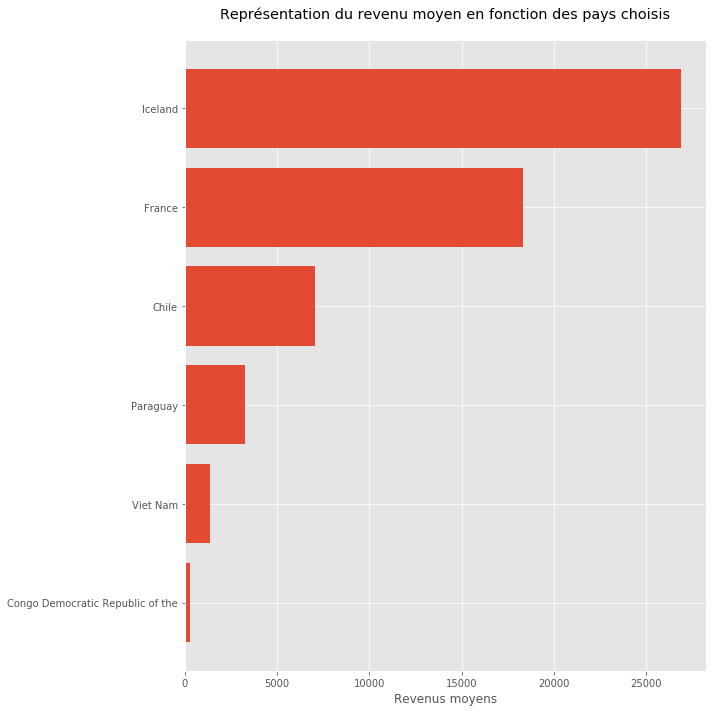

In [52]:
incm_inter = wid_fin2[(wid_fin2['Pays'] == 'France') |
                     (wid_fin2['Pays'] == 'Congo Democratic Republic of the') |
                     (wid_fin2['Pays'] == 'Viet Nam') |
                     (wid_fin2['Pays'] == 'Paraguay') |
                     (wid_fin2['Pays'] == 'Chile') |
                     (wid_fin2['Pays'] == 'Iceland')].sort_values('income')

# Paramètres généraux
plt.figure(figsize=(10,10))

# Paramètres graphiques
plt.barh(incm_inter.Pays, incm_inter.income)

# Métadonnées
plt.title('Représentation du revenu moyen en fonction des pays choisis\n')
plt.xlabel('Revenus moyens')
plt.tight_layout() # Permet de ne pas couper les labels

# Sauvegarde
plt.savefig('graphiques/Representation_du_revenu_moyen_en_fonction_des_pays_choisis.png')
plt.show()

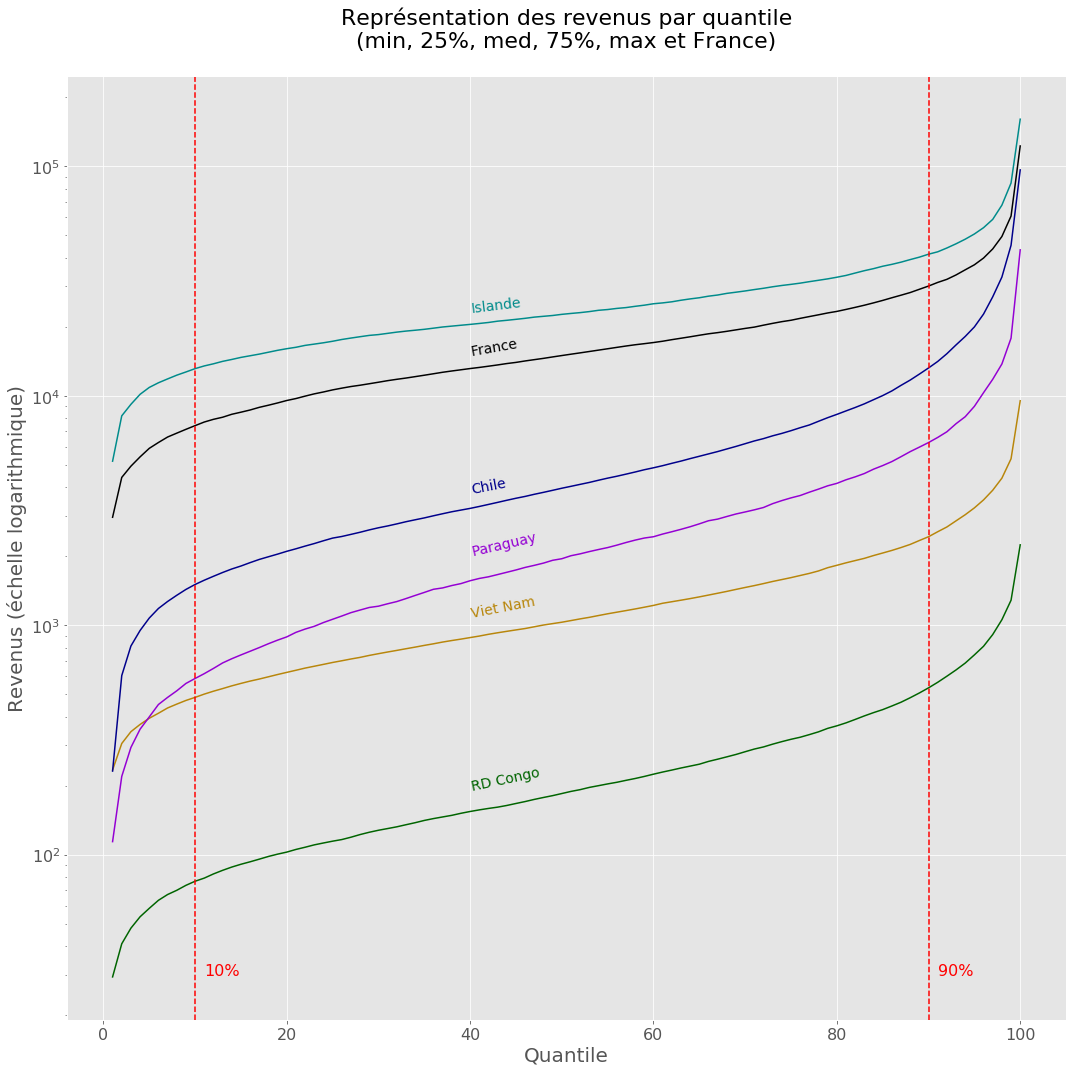

In [53]:
# Préparation des données par pays choisis
incm_fra = wid_fin1[wid_fin1['Pays'] == 'France']
incm_con = wid_fin1[wid_fin1['Pays'] == 'Congo Democratic Republic of the']
incm_vie = wid_fin1[wid_fin1['Pays'] == 'Viet Nam']
incm_par = wid_fin1[wid_fin1['Pays'] == 'Paraguay']
incm_chi = wid_fin1[wid_fin1['Pays'] == 'Chile']
incm_ice = wid_fin1[wid_fin1['Pays'] == 'Iceland']

# Création des labels
label = ['France',  'RD Congo (min)', 'Viet Nam (25%)', 'Paraguay (med)', 'Chile (75%)', 'Islande (max)']

# Paramètres généraux
plt.figure(figsize=(15,15))
plt.yscale('log')

# Paramètres des courbes
plt.plot(incm_fra['quantile'], incm_fra['income'], color='black')
plt.text(40, 15000 , 'France', fontsize = '14', color='black', rotation = 10)

plt.plot(incm_con['quantile'], incm_con['income'], color='darkgreen')
plt.text(40, 192 , 'RD Congo', fontsize = '14', color='darkgreen', rotation = 12)

plt.plot(incm_vie['quantile'], incm_vie['income'], color='darkgoldenrod')
plt.text(40, 1090 , 'Viet Nam', fontsize = '14', color='darkgoldenrod', rotation = 11)

plt.plot(incm_par['quantile'], incm_par['income'], color='darkviolet')
plt.text(40, 2030 , 'Paraguay', fontsize = '14', color='darkviolet', rotation = 13)

plt.plot(incm_chi['quantile'], incm_chi['income'], color='darkblue')
plt.text(40, 3750 , 'Chile', fontsize = '14', color='darkblue', rotation = 11)

plt.plot(incm_ice['quantile'], incm_ice['income'], color='darkcyan')
plt.text(40, 23100 , 'Islande', fontsize = '14', color='darkcyan', rotation = 7)

# Paramètre des lignes de référence
plt.axvline(10, linestyle='--', color='r')
plt.text(11, 30, '10%', color='r', fontsize=16)
plt.axvline(90, linestyle='--', color='r')
plt.text(91, 30, '90%', color='r', fontsize=16)

# Métadonnées
plt.title('Représentation des revenus par quantile\n(min, 25%, med, 75%, max et France)\n', fontsize=22)
plt.ylabel('Revenus (échelle logarithmique)', fontsize=20)
plt.yticks(fontsize=16)
plt.xlabel('Quantile', fontsize=20)
plt.xticks(fontsize=16)
plt.tight_layout()

# Sauvegarde
plt.savefig('graphiques/Representation_des_revenus_par_quantile.png')
plt.show()

### Représentation des distributions de revenus

La courbe de Lorenz va nous permettre de visualiser la distribution des revenus  
Une distribution parfaite serait la médiatrice du repère

[Haut de page](#sommaire)

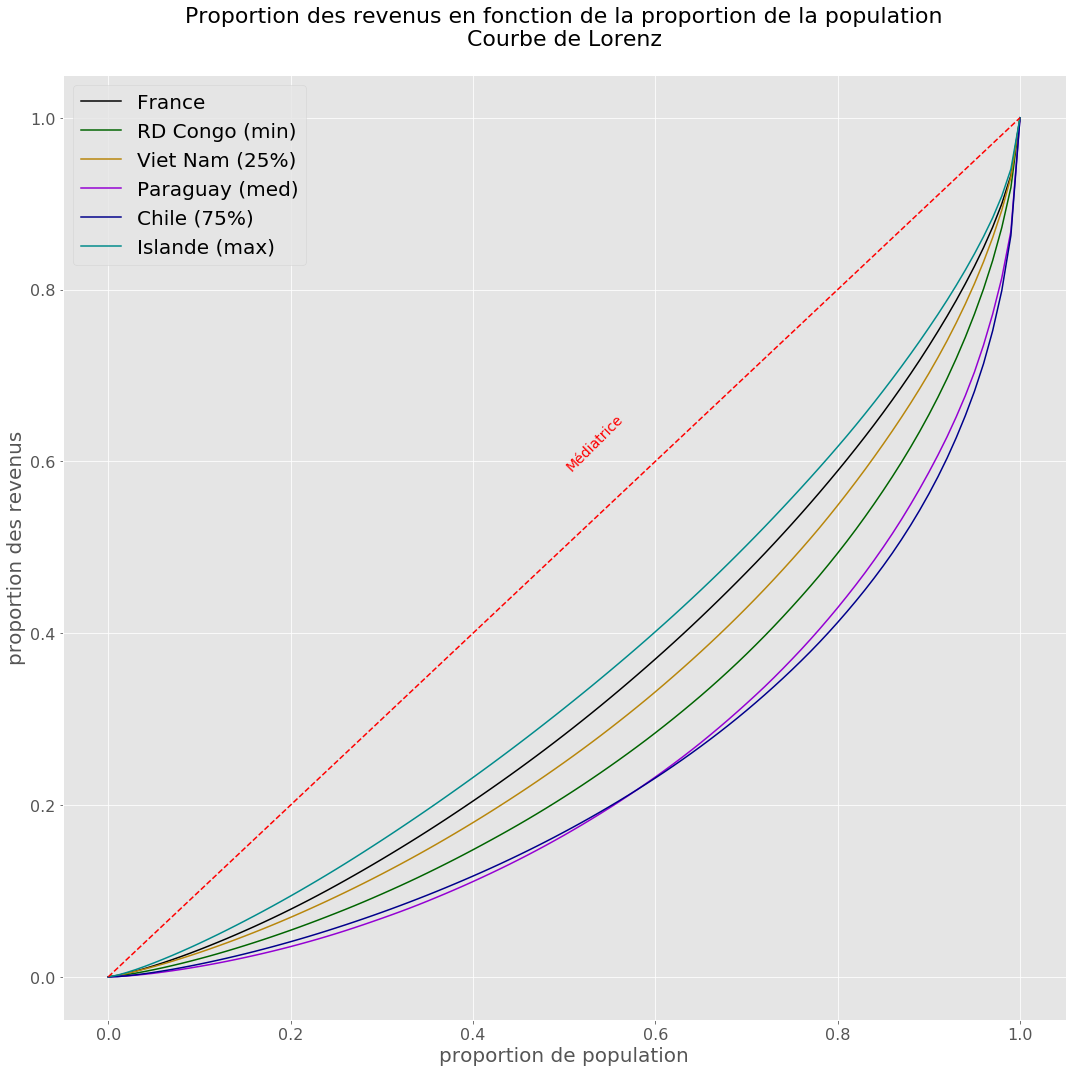

In [54]:
# Calculs des données des courbes de Lorenz
income_fra = incm_fra['income'].values
lorenz_fra = np.cumsum(np.sort(income_fra)) / income_fra.sum()
lorenz_fra = np.append([0], lorenz_fra)

income_con = incm_con['income'].values
lorenz_con = np.cumsum(np.sort(income_con)) / income_con.sum()
lorenz_con = np.append([0], lorenz_con)

income_vie = incm_vie['income'].values
lorenz_vie = np.cumsum(np.sort(income_vie)) / income_vie.sum()
lorenz_vie = np.append([0], lorenz_vie)

income_par = incm_par['income'].values
lorenz_par = np.cumsum(np.sort(income_par)) / income_par.sum()
lorenz_par = np.append([0], lorenz_par)

income_chi = incm_chi['income'].values
lorenz_chi = np.cumsum(np.sort(income_chi)) / income_chi.sum()
lorenz_chi = np.append([0], lorenz_chi)

income_ice = incm_ice['income'].values
lorenz_ice = np.cumsum(np.sort(income_ice)) / income_ice.sum()
lorenz_ice = np.append([0], lorenz_ice)

# Paramètres généraux
plt.figure(figsize=(15,15))

# Paramètres des courbes de Lorenz
plt.plot(np.linspace(0,1,len(lorenz_fra)),lorenz_fra, color='black')
plt.plot(np.linspace(0,1,len(lorenz_con)),lorenz_con, color='darkgreen')
plt.plot(np.linspace(0,1,len(lorenz_vie)),lorenz_vie, color='darkgoldenrod')
plt.plot(np.linspace(0,1,len(lorenz_par)),lorenz_par, color='darkviolet')
plt.plot(np.linspace(0,1,len(lorenz_chi)),lorenz_chi, color='darkblue')
plt.plot(np.linspace(0,1,len(lorenz_ice)),lorenz_ice, color='darkcyan')

# Paramètre de la médiatrice
x = [0, 1]
y = [0, 1]
plt.plot(x, y, 'red', linestyle='--', label='Médiatrice')
plt.text(0.5, 0.59, 'Médiatrice', fontsize=14, rotation = 45, color ='red')

# Métadonnées
plt.title('Proportion des revenus en fonction de la proportion de la population\nCourbe de Lorenz\n', fontsize=22)
plt.ylabel('proportion des revenus', fontsize=20)
plt.yticks(fontsize=16)
plt.xlabel('proportion de population', fontsize=20)
plt.xticks(fontsize=16)
plt.legend(label, prop={'size':20})
plt.tight_layout()

# Sauvegarde
plt.savefig('graphiques/Courbe_de_Lorenz.png')
plt.show()

### Evolution des indices de Gini

L'indice de Gini est le double de l'intégrale qui représente la surface entre la courbe de Lorenz et la médiatrice. Plus la répartition est égalitaire, plus l'indice de Gini se rapproche de 0  
Un indice de Gini égal à 1 signifierait qu'une seule personne possède 100% des revenus.

[Haut de page](#sommaire)

In [55]:
# Chargement du fichier
gini_brut = pd.read_csv('data/indices_gini.csv', skiprows=3, skipinitialspace=True, index_col=1)

# Mise en forme des données
gini_brut.reset_index(inplace=True)
gini_brut.rename(columns={'Country Name': 'Country'}, inplace =True)
gini_brut.drop(columns=['Country Code',
                      'Indicator Name',
                      'Indicator Code',
                       'Unnamed: 63'], inplace = True)
gini_brut.set_index('Country', inplace=True)
gini_brut = gini_brut.transform(lambda x: x / 100)

gini_brut.tail()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Country,,,,,,,,,,,,,,,,,,,,,
Kosovo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.318,0.333,0.278,0.29,0.263,0.273,0.265,0.267,0.29,NaN
"Yémen, Rép. du",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.367,NaN,NaN,NaN,NaN
Afrique du Sud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.634,NaN,NaN,NaN,0.630,NaN,NaN,NaN,NaN
Zambie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.556,NaN,NaN,NaN,NaN,0.571,NaN,NaN,NaN
Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.432,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Les données ont été téléchargées sur le site de <a href="https://donnees.banquemondiale.org/indicateur/si.pov.gini?view=map">La Banque Mondiale</a>  
data > Dimension: Inequality > Inequality: Income inequality, Gini coefficient<br/>

In [56]:
# Recherche de pays choisis en exemple
liste_pays = gini_brut.index
for i in liste_pays:
    if 'congo' in i.lower():
        print(i)
    if 'chil' in i.lower():
        print(i)
    if 'land' in i.lower():
        print(i)

Chili
Congo, République démocratique du
Congo, République du
Finlande
Groenland
Irlande
Islande
Nouvelle-Zélande
Thaïlande


In [57]:
# Données disponibles pour la France
gini_fra = gini_brut.loc[gini_brut.index == 'France'].iloc[0:].dropna(axis=1)
gini_fra

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,
France,0.314,0.306,0.298,0.297,0.324,0.33,0.327,0.337,0.333,0.331,0.325,0.323,0.327


In [58]:
# Données disponibles pour la République démocratique du Congo
gini_con = gini_brut.loc[gini_brut.index == 'Congo, République démocratique du'].iloc[0:].dropna(axis=1)
gini_con

,2004,2012
Country,,
"Congo, République démocratique du",0.422,0.421


In [59]:
# Données disponibles pour le Viet Nam
gini_vie = gini_brut.loc[gini_brut.index == 'Viet Nam'].iloc[0:].dropna(axis=1)
gini_vie

,1992,1998,2002,2004,2006,2008,2010,2012,2014,2016
Country,,,,,,,,,,
Viet Nam,0.357,0.354,0.37,0.368,0.358,0.356,0.393,0.356,0.348,0.353


In [60]:
# Données disponibles pour le Paraguay
gini_par = gini_brut.loc[gini_brut.index == 'Paraguay'].iloc[0:].dropna(axis=1)
gini_par

,1990,1995,1997,1999,2001,2002,2003,2004,2005,2006,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Country,,,,,,,,,,,,,,,,,,,,,
Paraguay,0.408,0.582,0.549,0.546,0.546,0.573,0.549,0.523,0.514,0.53,...,0.507,0.491,0.51,0.523,0.476,0.479,0.507,0.476,0.479,0.488


In [61]:
# Données disponibles pour le Chili
gini_chi = gini_brut.loc[gini_brut.index == 'Chili'].iloc[0:].dropna(axis=1)
gini_chi

,1987,1990,1992,1994,1996,1998,2000,2003,2006,2009,2011,2013,2015,2017
Country,,,,,,,,,,,,,,
Chili,0.562,0.572,0.548,0.564,0.549,0.555,0.528,0.515,0.482,0.49,0.476,0.473,0.477,0.466


In [62]:
# Données disponibles pour l'Islande
gini_ice = gini_brut.loc[gini_brut.index == 'Islande'].iloc[0:].dropna(axis=1)
gini_ice

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Country,,,,,,,,,,,,
Islande,0.268,0.28,0.29,0.302,0.295,0.318,0.287,0.262,0.268,0.268,0.254,0.278


In [63]:
# Restriction des données sur les pays concernés
gini = gini_brut.loc[(gini_brut.index == 'France') |
                    (gini_brut.index == 'Congo, République démocratique du') |
                    (gini_brut.index == 'Viet Nam') |
                    (gini_brut.index == 'Paraguay') |
                     (gini_brut.index == 'Chili' )|
                    (gini_brut.index =='Islande')].T

gini.index.name = 'year'

gini.tail()

Country,Chili,"Congo, République démocratique du",France,Islande,Paraguay,Viet Nam
year,,,,,,
2014,NaN,NaN,0.323,0.278,0.507,0.348
2015,0.477,NaN,0.327,NaN,0.476,NaN
2016,NaN,NaN,NaN,NaN,0.479,0.353
2017,0.466,NaN,NaN,NaN,0.488,NaN
2018,NaN,NaN,NaN,NaN,NaN,NaN


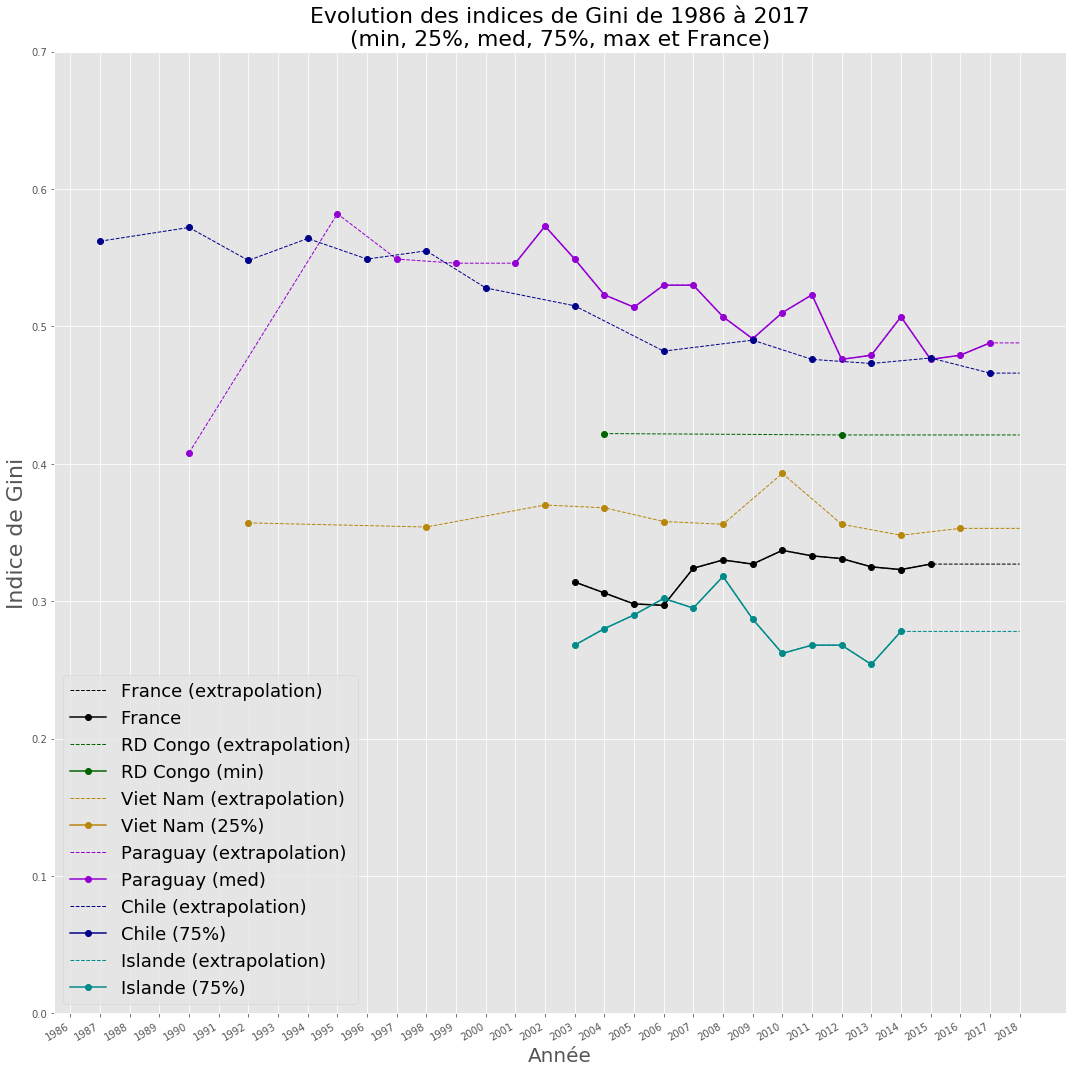

In [64]:
label = ['France (extrapolation)', 'France',
         'RD Congo (extrapolation)', 'RD Congo (min)', 
         'Viet Nam (extrapolation)', 'Viet Nam (25%)', 
         'Paraguay (extrapolation)', 'Paraguay (med)',
         'Chile (extrapolation)', 'Chile (75%)', 
         'Islande (extrapolation)', 'Islande (75%)']

# Paramètre généraux
fig, ax = plt.subplots(figsize=(15,15))

# Paramètres des courbes
# Lorsque j'ai des valeurs pour chaque année, le trait est plein
# Entre deux années non consécutives, le trait est pointillé
line, = ax.plot(gini['France'].interpolate(method='linear'),
                ls = '--', lw = 1, color='Black', label='')
ax.plot(gini['France'], color=line.get_color(), lw=1.5, marker = 'o')

line, = ax.plot(gini['Congo, République démocratique du'].interpolate(method='linear'),
                ls = '--', lw = 1, color='darkgreen', label='')
ax.plot(gini['Congo, République démocratique du'], color=line.get_color(), lw=1.5, marker = 'o')

line, = ax.plot(gini['Viet Nam'].interpolate(method='linear'),
                ls = '--', lw = 1, color='darkgoldenrod', label='')
ax.plot(gini['Viet Nam'], color=line.get_color(), lw=1.5, marker = 'o')

line, = ax.plot(gini['Paraguay'].interpolate(method='linear'),
                ls = '--', lw = 1, color='darkviolet', label='')
ax.plot(gini['Paraguay'], color=line.get_color(), lw=1.5, marker = 'o')

line, = ax.plot(gini['Chili'].interpolate(method='linear'),
                ls = '--', lw = 1, color='darkblue', label='')
ax.plot(gini['Chili'], color=line.get_color(), lw=1.5, marker = 'o')

line, = ax.plot(gini['Islande'].interpolate(method='linear'),
                ls = '--', lw = 1, color='darkcyan', label='')
ax.plot(gini['Islande'], color=line.get_color(), lw=1.5, marker = 'o')


# Métadonnées
plt.title('Evolution des indices de Gini de 1986 à 2017\n(min, 25%, med, 75%, max et France)', fontsize=22)
plt.xlabel('Année', fontsize=20)
plt.xticks(rotation=30, horizontalalignment='right')
plt.ylabel('Indice de Gini', fontsize = 22)
plt.ylim(0,0.7)
plt.legend(label, fontsize=18)
plt.tight_layout()

# Sauvegarde
plt.savefig('graphiques/Evolution_des_indices_de_Gini.png')
plt.show()

### Calcul de l'indice de Gini à partir du fichier de la World Income Distribution

[Haut de page](#sommaire)

In [65]:
# Liste des pays
key = wid_fin1['Pays'].drop_duplicates().values

# Création d'une colonne vide
wid_fin1['Gini'] = 0

# Calcul de l'indice de Gini pour chaque pays et remplissage de la colonne Gini
for i in key:
    income1 = wid_fin1.loc[wid_fin1['Pays'] == i].income.values
    lorenz = np.cumsum(np.sort(income1)) / income1.sum()
    lorenz = np.append([0], lorenz)
    wid_fin1.loc[wid_fin1['Pays'] == i, 'Gini'] = 2 * (0.5 - (lorenz[:-1].sum() / len(lorenz)))

wid_fin1.head()

,Pays,quantile,income,gdpppp,ISO3,Population,Gini
0,Albania,1,728.89795,7297.0,ALB,2947314.0,0.32141
1,Albania,2,916.66235,7297.0,ALB,2947314.0,0.32141
2,Albania,3,1010.91600,7297.0,ALB,2947314.0,0.32141
3,Albania,4,1086.90780,7297.0,ALB,2947314.0,0.32141
4,Albania,5,1132.69970,7297.0,ALB,2947314.0,0.32141


In [66]:
# Sélection des pays suivis
comp_gini = wid_fin1.loc[(wid_fin1['Pays'] == 'France') |
             (wid_fin1['Pays'] == 'Congo Democratic Republic of the') |
             (wid_fin1['Pays'] == 'Viet Nam') |
             (wid_fin1['Pays'] == 'Paraguay') |
             (wid_fin1['Pays'] == 'Chile') |
             (wid_fin1['Pays'] == 'Iceland')].groupby('Pays').mean()

comp_gini

,quantile,income,gdpppp,Population,Gini
Pays,,,,,
Chile,50.5,7051.609966,13390.00000,16661942.0,0.546115
Congo Democratic Republic of the,50.5,276.016044,303.19305,60373608.0,0.459403
France,50.5,18309.407545,30357.00000,64374989.0,0.345640
Iceland,50.5,26888.511518,36527.00000,317414.0,0.302046
Paraguay,50.5,3278.080965,4347.00000,6047117.0,0.539729
Viet Nam,50.5,1377.773966,2578.00000,86707801.0,0.393546


In [67]:
# Ajout des coefficients téléchargés sur le site de la banque mondiale
comp_gini['gini2'] = gini_brut[(gini_brut.index == 'France') |
          (gini_brut.index == 'Congo, République démocratique du') |
         (gini_brut.index == 'Viet Nam') |
         (gini_brut.index == 'Paraguay') |
         (gini_brut.index == 'Chili') |
         (gini_brut.index == 'Islande')]['2008'].values

# La valeur de 2009 est choisie pour le Chili
comp_gini.loc[comp_gini.index == 'Chile', 'gini2'] = gini_brut[gini_brut.index == 'Chili']['2009'].values

# Pas de données pour le Congo

comp_gini['Différence de Gini'] = 100 * (comp_gini['Gini'] - comp_gini['gini2']) / comp_gini['Gini']
comp_gini

,quantile,income,gdpppp,Population,Gini,gini2,Différence de Gini
Pays,,,,,,,
Chile,50.5,7051.609966,13390.00000,16661942.0,0.546115,0.490,10.275263
Congo Democratic Republic of the,50.5,276.016044,303.19305,60373608.0,0.459403,NaN,NaN
France,50.5,18309.407545,30357.00000,64374989.0,0.345640,0.330,4.524895
Iceland,50.5,26888.511518,36527.00000,317414.0,0.302046,0.318,-5.281825
Paraguay,50.5,3278.080965,4347.00000,6047117.0,0.539729,0.507,6.063980
Viet Nam,50.5,1377.773966,2578.00000,86707801.0,0.393546,0.356,9.540322


### Classement par indice de Gini

[Haut de page](#sommaire)

In [68]:
# Classement selon l'indice de Gini
wid_fin3 = wid_fin1.groupby(by='Pays').mean()
rank_gini = wid_fin3.sort_values(by='Gini', ascending=False)
rank_gini.reset_index(inplace=True)

# Les 5 pays avec le plus haut indice de Gini
max_five_gini = rank_gini.head()

max_five_gini

,Pays,quantile,income,gdpppp,Population,Gini
0,South Africa,50.5,5617.904880,9602.0,50412129.0,0.682949
1,Honduras,50.5,3296.268419,3628.0,7872658.0,0.615512
2,Colombia,50.5,3547.005276,8185.0,44901544.0,0.583437
3,Guatemala,50.5,2142.474753,4367.0,14006366.0,0.582468
4,Central African Republic,50.5,811.299901,685.0,4345386.0,0.575972


In [69]:
# Moyenne de l'indice de Gini des 5 plus forts indices
max_five_gini['Gini'].mean()

0.6080675959510912

In [70]:
# Les 5 pays avec le plus faible indice de Gini
min_five_gini = rank_gini.tail()

min_five_gini

,Pays,quantile,income,gdpppp,Population,Gini
111,Ukraine,50.5,3349.388306,6721.0,46258200.0,0.272415
112,Sweden,50.5,16184.222707,34371.0,9219637.0,0.272166
113,Czech Republic,50.5,8235.293411,23223.0,10384603.0,0.270162
114,Slovakia,50.5,6096.579894,20515.0,5379233.0,0.264573
115,Slovenia,50.5,12106.007475,27197.0,2021316.0,0.248249


In [71]:
# Moyenne de l'indice de Gini des 5 plus faible indices
min_five_gini['Gini'].mean()

0.26551310572405

In [72]:
# Position de la France (77 ème)
rank_gini.loc[rank_gini['Pays'] == 'France']

,Pays,quantile,income,gdpppp,Population,Gini
76,France,50.5,18309.407545,30357.0,64374989.0,0.34564


<a id='m3'></a>
## Recherche de la classe de revenus des parents par un coefficient d'élasticité

Un coefficient d'élasticité (IGEincome) est la propension pour un individu d'une classe, d'avoir des parents issus d'une autre classe que la sienne. Il s'obtient à 'aide d'une regression linéaire simple dans laquelle le logarithme du revenu de l'enfant est une fonction du logarithme du revenu des parents.  
C'est la mobilité intergénérationnelle du revenu.  
(Voir page 8 du document 2011_measuring_intergenerational_income_mobility.pdf dans ressources_documentaires)

### Ajout du coefficient d'élasticité

[Haut de page](#sommaire)

In [73]:
# Chargement du fichier de la banque mondiale
gdim = pd.read_csv('data/gdim.csv')

# Projection sur les colonnes utiles
gdima = gdim[['countryname', 'iso3', 'region', 'incgroup4', 'year', 'IGEincome']]

# Copie du dataframe initial
gdimb = gdima.copy()

# Création d'une colonne regroupant l'appelation 'region' et 'incgroup4'
gdimb['Group'] = gdimb[['region', 'incgroup4']].apply(lambda x: ', '.join(x), axis=1)

gdimb.head()

,countryname,iso3,region,incgroup4,year,IGEincome,Group
0,Afghanistan,AFG,South Asia,Low income,1980,NaN,"South Asia, Low income"
1,Afghanistan,AFG,South Asia,Low income,1980,NaN,"South Asia, Low income"
2,Afghanistan,AFG,South Asia,Low income,1980,NaN,"South Asia, Low income"
3,Afghanistan,AFG,South Asia,Low income,1980,NaN,"South Asia, Low income"
4,Afghanistan,AFG,South Asia,Low income,1980,NaN,"South Asia, Low income"


In [74]:
# Calcul des 'IGEincome'  moyen par région et groupe de revenus
frt6 = gdimb.groupby(['region', 'incgroup4', 'Group']).mean()[['IGEincome']]
frt6.reset_index(inplace=True)
frt6.set_index('Group', inplace=True)

frt6

,region,incgroup4,IGEincome
Group,,,
"East Asia & Pacific, Lower middle income",East Asia & Pacific,Lower middle income,0.527665
"East Asia & Pacific, Upper middle income",East Asia & Pacific,Upper middle income,0.469500
"Europe & Central Asia, Lower middle income",Europe & Central Asia,Lower middle income,0.424817
"Europe & Central Asia, Upper middle income",Europe & Central Asia,Upper middle income,0.477171
"High income, High income",High income,High income,0.348050
"Latin America & Caribbean, Lower middle income",Latin America & Caribbean,Lower middle income,0.940737
"Latin America & Caribbean, Upper middle income",Latin America & Caribbean,Upper middle income,0.878852
"Middle East & North Africa, Lower middle income",Middle East & North Africa,Lower middle income,0.916461
"Middle East & North Africa, Upper middle income",Middle East & North Africa,Upper middle income,0.517398


In [75]:
# Affectation de la valeur moyenne du fichier elasticity.txt pour la zone 'Asie'  - 'Base case'
# Voir dans ressources_documentaires pour plus d'informations sur le fichier elasticity.txt
gdimb.loc[(gdimb['region'] == 'South Asia') &
          (gdimb['incgroup4'] == 'Upper middle income'), 'IGEincome'] = 0.5

In [76]:
# Vérification des années existantes pour l'IGEincome
frt4 = gdimb.groupby(by='year').nunique()
frt4

,countryname,iso3,region,incgroup4,year,IGEincome,Group
year,,,,,,,
1940,107,107,7,4,1,0,14
1950,110,110,7,4,1,0,14
1960,114,114,7,4,1,38,14
1970,111,111,7,4,1,36,14
1980,147,147,7,4,1,2,15


In [77]:
# Création d'un dataframe avec les 'IGEincome' en colonnes
gdimc = pd.pivot_table(gdimb, values='IGEincome', index={'countryname'}, columns='year', dropna=False)
gdimc.reset_index(inplace=True)
gdimc.set_index('countryname', inplace=True)

gdimc.head(3)

year,1940,1950,1960,1970,1980
countryname,,,,,
Afghanistan,NaN,NaN,NaN,NaN,NaN
Albania,NaN,NaN,NaN,0.815874,NaN
Angola,NaN,NaN,NaN,NaN,NaN


In [78]:
# Jointure et mise en forme du dataframe  
gdimd = pd.merge(gdimb, gdimc, on='countryname')
gdimd.drop(columns=['year', 'IGEincome'], inplace=True)
gdimd.set_index('countryname', inplace=True)

gdimd.head(3)

,iso3,region,incgroup4,Group,1940,1950,1960,1970,1980
countryname,,,,,,,,,
Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",NaN,NaN,NaN,NaN,NaN
Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",NaN,NaN,NaN,NaN,NaN
Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",NaN,NaN,NaN,NaN,NaN


In [79]:
# Vérification des valeurs nulles
gdimd.isnull().sum()

iso3            0
region          0
incgroup4       0
Group           0
1940         6504
1950         6504
1960         4420
1970         4442
1980         6432
dtype: int64

In [80]:
# Vérification de l'existence d'un seul coefficient d'elasticité par pays
frt2 = gdimd.groupby(by='countryname').nunique()
frt2['test_annee'] = frt2[1940] + frt2[1950] + frt2[1960] + frt2[1970] + frt2[1980]
frt2.loc[frt2['test_annee'] > 1]

,iso3,region,incgroup4,Group,1940,1950,1960,1970,1980,test_annee
countryname,,,,,,,,,,


In [81]:
# Nombre de pays sans coefficient d'élasticité
len(frt2.loc[frt2['test_annee'] == 0])

74

In [82]:
# Aggrégation par pays selon la moyenne
gdime = gdimd.groupby(by=['countryname', 'iso3', 'region', 'incgroup4', 'Group']).mean()
gdime.reset_index(inplace=True)
gdime.set_index('countryname', inplace = True)

# Remplacement des 'NaN' par une string 'rien'
gdime.fillna('rien', inplace=True)

gdime.head(3)

,iso3,region,incgroup4,Group,1940,1950,1960,1970,1980
countryname,,,,,,,,,
Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",rien,rien,rien,rien,rien
Albania,ALB,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",rien,rien,rien,0.815874,rien
Angola,AGO,Sub-Saharan Africa,Upper middle income,"Sub-Saharan Africa, Upper middle income",rien,rien,rien,rien,rien


In [83]:
# Création d'une clef pour itérer
key1 = gdime.index
key1

Index(['Afghanistan', 'Albania', 'Angola', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus',
       ...
       'United Kingdom', 'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu',
       'Venezuela, RB', 'Vietnam', 'West Bank and Gaza', 'Yemen, Rep.',
       'Zambia'],
      dtype='object', name='countryname', length=150)

In [84]:
# Ajout du coefficient d'élasticité le plus récent 
# Ou de du coefficient moyen pour la région d'appartenance d'un pays
for i in key1:
    if gdime.loc[i, 1980] != 'rien':
        gdime.loc[i, [1940, 1950, 1960, 1970]] = gdime.loc[i, 1980] # Si il existe une valeur en 1980
                                                                    #elle est propagée
    elif gdime.loc[i, 1970] != 'rien':
        gdime.loc[i, [1940, 1950, 1960, 1980]] = gdime.loc[i, 1970] # Sinon, si il existe une valeur en 1970
                                                                    # Elle est propagée
    
    elif gdime.loc[i, 1960] != 'rien':
        gdime.loc[i, [1940, 1950, 1970, 1980]] = gdime.loc[i, 1960] # Sinon, si il existe une valeur en 1960
                                                                    #elle est propagée
    
    elif ((gdime.loc[i, 1980] == 'rien') and
              (gdime.loc[i, 1970] == 'rien') and
              (gdime.loc[i, 1960] == 'rien') and
              (gdime.loc[i, 1950] == 'rien') and
              (gdime.loc[i, 1940] == 'rien')): # Si il n'y a aucune valeur
                                               # On choisi la valeur moyenne de la région
                                               #du niveau de revenu
            k = gdime.loc[i, 'Group']
            gdime.loc[i, [1940, 1950, 1950, 1960, 1970, 1980]] = frt6.loc[k, 'IGEincome']

In [85]:
gdime.isnull().sum()

iso3         0
region       0
incgroup4    0
Group        0
1940         0
1950         0
1960         0
1970         0
1980         0
dtype: int64

In [86]:
# Assignation du type float pour les colonnes contenant les IGEincome
gdime[[1940, 1950, 1960, 1970, 1980]] = gdime[[1940, 1950, 1960, 1970, 1980]].astype(float)

gdime.dtypes

iso3          object
region        object
incgroup4     object
Group         object
1940         float64
1950         float64
1960         float64
1970         float64
1980         float64
dtype: object

In [87]:
gdime.reset_index(inplace=True)
gdime.head(3)

,countryname,iso3,region,incgroup4,Group,1940,1950,1960,1970,1980
0,Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",0.436000,0.436000,0.436000,0.436000,0.436000
1,Albania,ALB,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874,0.815874,0.815874,0.815874,0.815874
2,Angola,AGO,Sub-Saharan Africa,Upper middle income,"Sub-Saharan Africa, Upper middle income",0.677000,0.677000,0.677000,0.677000,0.677000


In [88]:
# Mise en forme du dataframe
gdimf = gdime.drop(columns=[1940,1950,1960,1970]).rename(columns={'countryname': 'pays',
                                                                  'iso3': 'ISO3',
                                                                  1980: 'Coef Elas'})
gdimf.reset_index(inplace=True, drop=True)

gdimf.head(3)

,pays,ISO3,region,incgroup4,Group,Coef Elas
0,Afghanistan,AFG,South Asia,Low income,"South Asia, Low income",0.436000
1,Albania,ALB,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
2,Angola,AGO,Sub-Saharan Africa,Upper middle income,"Sub-Saharan Africa, Upper middle income",0.677000


In [89]:
# Vérification des valeurs moyennes par région et niveau de revenus
gdimf.groupby(by='Group').mean()

,Coef Elas
Group,
"East Asia & Pacific, Lower middle income",0.527665
"East Asia & Pacific, Upper middle income",0.469500
"Europe & Central Asia, Lower middle income",0.424817
"Europe & Central Asia, Upper middle income",0.477171
"High income, High income",0.346502
"Latin America & Caribbean, Lower middle income",0.940737
"Latin America & Caribbean, Upper middle income",0.878852
"Middle East & North Africa, Lower middle income",0.916461
"Middle East & North Africa, Upper middle income",0.517398


In [90]:
# Recherche des codes pays communs aux deux fichiers
pays_gdim = gdimf.ISO3.unique()
pays = wid_fin1.ISO3.unique()
ctrl = np.intersect1d(pays, pays_gdim)

len(ctrl)

114

In [91]:
# Jointure de wid_fin1 et gdime
ready_db = pd.merge(wid_fin1, gdimf, how='left', on='ISO3' )

# Suppression des colonnes inutiles
ready_db.drop(columns=['pays'], inplace=True)

ready_db.head()

,Pays,quantile,income,gdpppp,ISO3,Population,Gini,region,incgroup4,Group,Coef Elas
0,Albania,1,728.89795,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
1,Albania,2,916.66235,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
2,Albania,3,1010.91600,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
3,Albania,4,1086.90780,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
4,Albania,5,1132.69970,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874


In [92]:
# Recherche des valleurs nulles ou manquantes
ready_db.isnull().sum()

Pays            0
quantile        0
income          0
gdpppp          0
ISO3            0
Population      0
Gini            0
region        200
incgroup4     200
Group         200
Coef Elas     200
dtype: int64

In [93]:
# Affichage des lignes incomplètes
ready_db.loc[ready_db['region'].isnull()].groupby(by=['Pays', 'ISO3']).nunique()

,,Pays,quantile,income,gdpppp,ISO3,Population,Gini,region,incgroup4,Group,Coef Elas
Pays,ISO3,,,,,,,,,,,
Kosovo,XKX,1,100,100,1,1,1,1,0,0,0,0
Syrian Arab Republic (Syria),SYR,1,100,100,1,1,1,1,0,0,0,0


Les données proviennent de la version anglaise du site de la <a href="http://www.fao.org/faostat/fr/#data">FAO</a>  
English > Population > Annual population > REGIONS > Africa > (list)<br/>

In [94]:
# Recherche de ces pays dans gdim
for i in pays_gdim:
    if 'k' in i.lower():
        print(i)
    elif 'sy' in i.lower():
        print(i)
    elif 'sr' in i.lower():
        print(i)

KHM
DNK
ISR
KAZ
KEN
KIR
KOR
KSV
KGZ
MKD
PAK
SRB
SVK
LKA
TJK
UKR


In [95]:
# Affichage des valeurs retrouvées manuellement
gdimf.loc[gdimf['ISO3'] == 'KSV']

,pays,ISO3,region,incgroup4,Group,Coef Elas
71,Kosovo,KSV,Europe & Central Asia,Lower middle income,"Europe & Central Asia, Lower middle income",0.424817


In [96]:
# Saisie manuelle
ready_db.loc[ready_db['Pays'] == 'Kosovo', ['region', 'incgroup4', 'Group', 'Coef Elas']] =\
['Europe & Central Asia', 'Lower middle income', 'Europe & Central Asia, Lower middle income', 0.424817]

ready_db.loc[ready_db['Pays'] == 'Kosovo'].head(1)

,Pays,quantile,income,gdpppp,ISO3,Population,Gini,region,incgroup4,Group,Coef Elas
11300,Kosovo,1,437.8937,7530.632,XKX,1747400.0,0.331163,Europe & Central Asia,Lower middle income,"Europe & Central Asia, Lower middle income",0.424817


In [97]:
#Affichage des informations sur la Syrie
ready_db.loc[ready_db['Pays'] == 'Syrian Arab Republic (Syria)'].groupby(['Pays']).mean()

,quantile,income,gdpppp,Population,Gini,Coef Elas
Pays,,,,,,
Syrian Arab Republic (Syria),50.5,685.817495,4512.0,20325443.0,0.373873,NaN


In [98]:
# Restriction sur les pays du même Group
inter = ready_db.loc[ready_db['Group'] == 'Middle East & North Africa, Lower middle income'].groupby('Pays').mean()
inter.reset_index(inplace=True)

# Restriction sur les pays de la même région
inter

,Pays,quantile,income,gdpppp,Population,Gini,Coef Elas
0,Egypt,50.5,1969.577399,5011.00,80953881.0,0.347097,0.943205
1,Morocco,50.5,2337.600601,3973.00,31596855.0,0.422964,0.945745
2,Palestinian Territory Occupied,50.5,1114.098514,3612.14,3596688.0,0.371354,0.916461
3,Yemen,50.5,1042.635870,2224.00,22356391.0,0.390259,0.916461


In [99]:
# Calcul du Coef. d'Elas moyen des pays similaires
coef_elas_moy_syr = inter['Coef Elas'].mean()

In [100]:
# Affectation manuelle
ready_db.loc[ready_db['Pays'] == 'Syrian Arab Republic (Syria)',
             ['region',
              'incgroup4',
              'Group',
              'Coef Elas']] = ['Middle East & North Africa',
                               'Upper middle income',
                               'Middle East & North Africa, Upper middle income',
                               coef_elas_moy_syr]

ready_db.loc[ready_db['Pays'] == 'Syrian Arab Republic (Syria)'].head(3)

,Pays,quantile,income,gdpppp,ISO3,Population,Gini,region,incgroup4,Group,Coef Elas
10000,Syrian Arab Republic (Syria),1,143.18066,4512.0,SYR,20325443.0,0.373873,Middle East & North Africa,Upper middle income,"Middle East & North Africa, Upper middle income",0.930468
10001,Syrian Arab Republic (Syria),2,179.06183,4512.0,SYR,20325443.0,0.373873,Middle East & North Africa,Upper middle income,"Middle East & North Africa, Upper middle income",0.930468
10002,Syrian Arab Republic (Syria),3,195.83022,4512.0,SYR,20325443.0,0.373873,Middle East & North Africa,Upper middle income,"Middle East & North Africa, Upper middle income",0.930468


In [101]:
# Vérification des valeurs nulles
ready_db.isnull().sum()

Pays          0
quantile      0
income        0
gdpppp        0
ISO3          0
Population    0
Gini          0
region        0
incgroup4     0
Group         0
Coef Elas     0
dtype: int64

In [102]:
ready_db.head()

,Pays,quantile,income,gdpppp,ISO3,Population,Gini,region,incgroup4,Group,Coef Elas
0,Albania,1,728.89795,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
1,Albania,2,916.66235,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
2,Albania,3,1010.91600,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
3,Albania,4,1086.90780,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
4,Albania,5,1132.69970,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874


In [103]:
ready_db.shape

(11600, 11)

### Protocole du calcul de distribution condition conditionnelles

[Haut de page](#sommaire)

In [104]:
#  Définition des paramètres
nb_quantiles = 10
n = 1000 * nb_quantiles
pj = 0.9

# Génération selon la loi Normale
ln_y_parent = st.norm(0,1).rvs(size=n)
residus = st.norm(0,1).rvs(size=n)

# Calcul des revenus des parents et des enfants
y_child = np.exp(pj * ln_y_parent + residus)
y_parents = np.exp(ln_y_parent)

# Conversion des tableaux en series
y_child = pd.Series(y_child)
y_parents = pd.Series(y_parents)

# Détermination de la classe de revenus des enfants
size_child = len(y_child)
l_sorted_child = y_child.copy()
l_sorted_child = l_sorted_child.sort_values()
quantiles_child = np.round(np.arange(1,
                                     nb_quantiles + 1,
                                     nb_quantiles / size_child) - 0.5 + 1./size_child)
q_dict_child = {a: int(b) for a, b in zip(l_sorted_child, quantiles_child)}
c_i_child = pd.Series(q_dict_child[e] for e in  y_child)

# Détermination de la classe de revenus des enfants
size_parents = len(y_parents)
l_sorted_parents = y_parents.copy()
l_sorted_parents = l_sorted_parents.sort_values()
quantiles_parents = np.round(np.arange(1,
                                       nb_quantiles + 1,
                                       nb_quantiles / size_parents) - 0.5 + 1./size_parents)
q_dict_parents = {a: int(b) for a, b in zip(l_sorted_parents, quantiles_parents)}
c_i_parent = pd.Series(q_dict_parents[e] for e in  y_parents)

# Mise en forme
sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis = 1)
sample.columns = ['y_child', 'y_parents', 'c_i_child', 'c_i_parent']

In [105]:
sample.head()

,y_child,y_parents,c_i_child,c_i_parent
0,1.932833,1.388422,7,7
1,1.441730,0.875910,7,5
2,0.421249,1.219316,3,6
3,1.354620,0.894653,6,5
4,1.182368,0.672320,6,4


In [106]:
# On compte chaque combinaison c_i_child, c_i_parent
counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
counts = counts.reset_index()
counts.columns = ["c_i_child","c_i_parent","counts"]

counts.head(3)

,c_i_child,c_i_parent,counts
0,1,1,466
1,1,2,216
2,1,3,130


In [107]:
# On divise le nombre d'individus compté par le nombre d'individus total pour chaque quantile parent

distrib = []
total = counts["counts"].sum()

for q_p in range(1, nb_quantiles+1):
    subset = counts[counts.c_i_parent == q_p]
    if len(subset):
        nb = subset["counts"].values[0]
        distrib += [nb / total]
    else:
        distrib += [0]
print(len(distrib), total, distrib)

10 10000 [0.0466, 0.0216, 0.013, 0.0067, 0.006, 0.0028, 0.0017, 0.001, 0.0004, 0.0002]


In [108]:
# Pour chaque quantile enfant, on crée la ligne de distribution du c_i_parent
# Ces opérations et les précedentes seront réalisées par la fonction distribution()
# Qui prend pour arguments:
# 1- le dataframe avec les classes de revenu enfant et parent
# Pour compter le nombre de chaque combinaison classe paretn/classe enfant
# 2- le nombre de quantiles

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib  

mat = []

for child_quantile in np.arange(nb_quantiles)+1:
    subset = counts[counts.c_i_child == child_quantile]
    mat += [distribution(subset, nb_quantiles)]
    
cd = np.array(mat)

cd

array([[0.466, 0.216, 0.13 , 0.067, 0.06 , 0.028, 0.017, 0.01 , 0.004,
        0.002],
       [0.206, 0.22 , 0.157, 0.166, 0.092, 0.067, 0.048, 0.029, 0.012,
        0.003],
       [0.126, 0.178, 0.17 , 0.127, 0.118, 0.11 , 0.081, 0.05 , 0.03 ,
        0.01 ],
       [0.082, 0.127, 0.162, 0.14 , 0.129, 0.108, 0.103, 0.085, 0.045,
        0.019],
       [0.05 , 0.098, 0.121, 0.134, 0.138, 0.128, 0.125, 0.084, 0.075,
        0.047],
       [0.029, 0.079, 0.103, 0.109, 0.141, 0.146, 0.118, 0.123, 0.101,
        0.051],
       [0.026, 0.042, 0.066, 0.107, 0.114, 0.126, 0.157, 0.144, 0.128,
        0.09 ],
       [0.011, 0.024, 0.056, 0.084, 0.098, 0.139, 0.137, 0.155, 0.174,
        0.122],
       [0.004, 0.011, 0.026, 0.046, 0.081, 0.081, 0.135, 0.185, 0.227,
        0.204],
       [0.   , 0.005, 0.009, 0.02 , 0.029, 0.067, 0.079, 0.135, 0.204,
        0.452]])

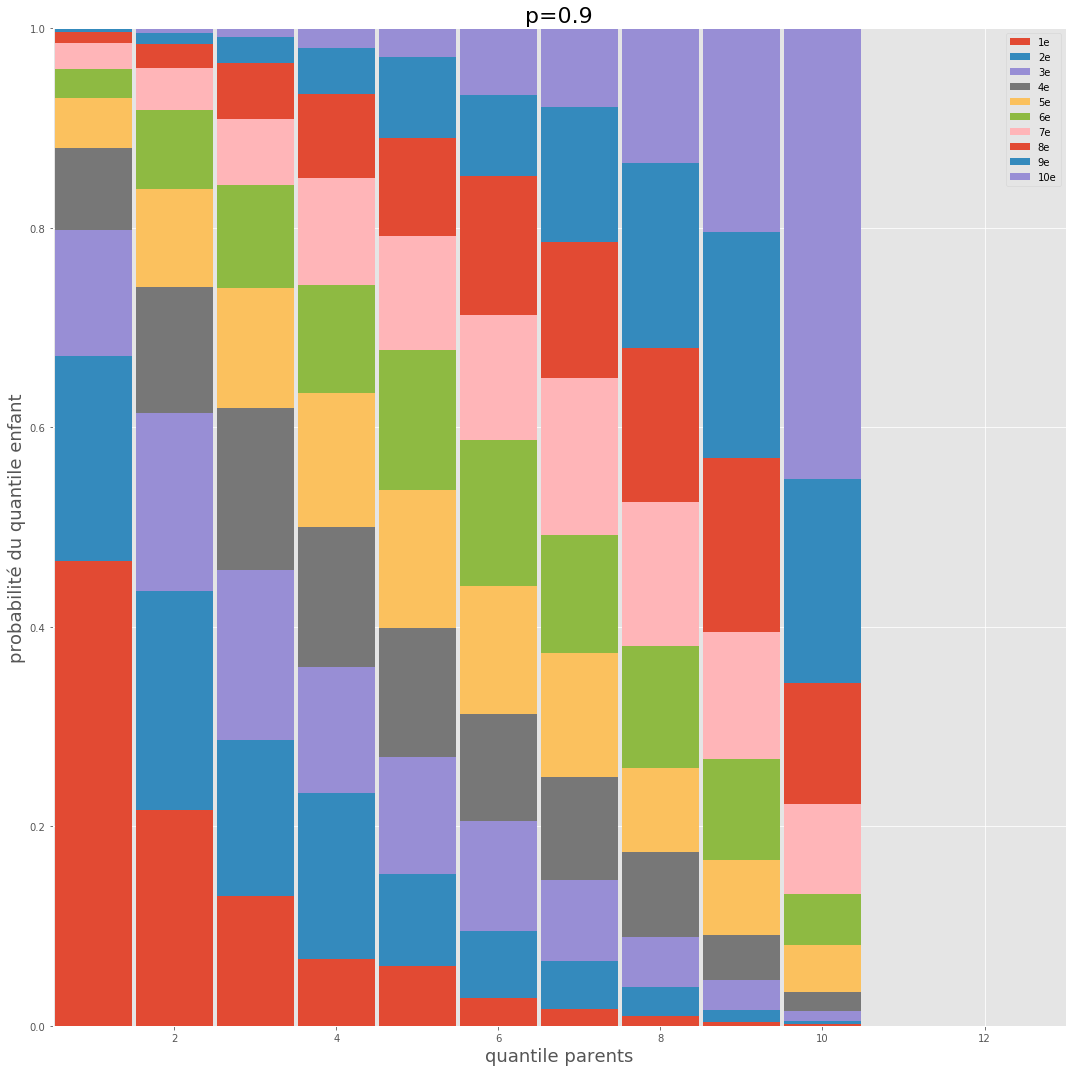

In [109]:
# Graphique pour une faible mobilité
plt.figure(figsize=(15,15))
cumul = np.array([0] * nb_quantiles)
for i, child_quantile in enumerate(cd):
    plt.bar(np.arange(nb_quantiles) + 1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) + 'e')
    cumul = cumul + np.array(child_quantile)
    
plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
plt.title('p=' + str(pj), fontsize=22)
plt.legend()
plt.xlabel('quantile parents', fontsize=18)
plt.ylabel('probabilité du quantile enfant', fontsize=18)
plt.tight_layout()

plt.savefig('graphiques/exemple_faible_mobilite_intergenerationnelle.png')
plt.show()

In [110]:
# Sachant que la classe de revenus d'un enfant est 1 et Coef Elas est 0.9 (faible mobilité)
# Alors la probabilité que la classe de revenus du parent soit 0 est:
c_i_child = 0
c_i_parent = 0
p = cd[c_i_parent, c_i_child]

print('\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}'.format(c_i_parent+1, c_i_child+1, pj, p))


P(c_i_parent = 1 | c_i_child = 1, pj = 0.9) = 0.466


In [111]:
# Sachant que la classe de revenus d'un enfant est 1 et Coef Elas est 0.9 (faible mobilité)
# Alors la probabilité que la classe de revenus du parent soit 10 est:
c_i_child = 0
c_i_parent = 9
p = cd[c_i_child, c_i_parent]

print('\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}'.format(c_i_parent+1, c_i_child+1, pj, p))


P(c_i_parent = 10 | c_i_child = 1, pj = 0.9) = 0.002


In [112]:
# Définition de nouveaux paramètres pour une forte mobilité
# (Les calculs détaillés dans les cellules précédentes ont été mis sous forme de fonction)

def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final
    # (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

pj1 = 0.1
y_child1, y_parents1 = generate_incomes(n, pj1)
sample1 = compute_quantiles(y_child1, y_parents1, nb_quantiles)
cd1 = conditional_distributions(sample1, nb_quantiles)
cd1

array([[0.125, 0.096, 0.118, 0.11 , 0.106, 0.092, 0.094, 0.091, 0.081,
        0.087],
       [0.124, 0.121, 0.099, 0.109, 0.08 , 0.096, 0.106, 0.091, 0.081,
        0.093],
       [0.108, 0.11 , 0.097, 0.095, 0.095, 0.109, 0.109, 0.097, 0.102,
        0.078],
       [0.099, 0.112, 0.092, 0.106, 0.099, 0.104, 0.095, 0.093, 0.12 ,
        0.08 ],
       [0.097, 0.101, 0.115, 0.107, 0.102, 0.111, 0.098, 0.102, 0.085,
        0.082],
       [0.1  , 0.105, 0.123, 0.089, 0.085, 0.084, 0.098, 0.113, 0.089,
        0.114],
       [0.086, 0.094, 0.097, 0.097, 0.108, 0.107, 0.105, 0.088, 0.108,
        0.11 ],
       [0.091, 0.103, 0.103, 0.091, 0.119, 0.101, 0.096, 0.096, 0.102,
        0.098],
       [0.09 , 0.082, 0.09 , 0.098, 0.092, 0.091, 0.112, 0.099, 0.133,
        0.113],
       [0.08 , 0.076, 0.066, 0.098, 0.114, 0.105, 0.087, 0.13 , 0.099,
        0.145]])

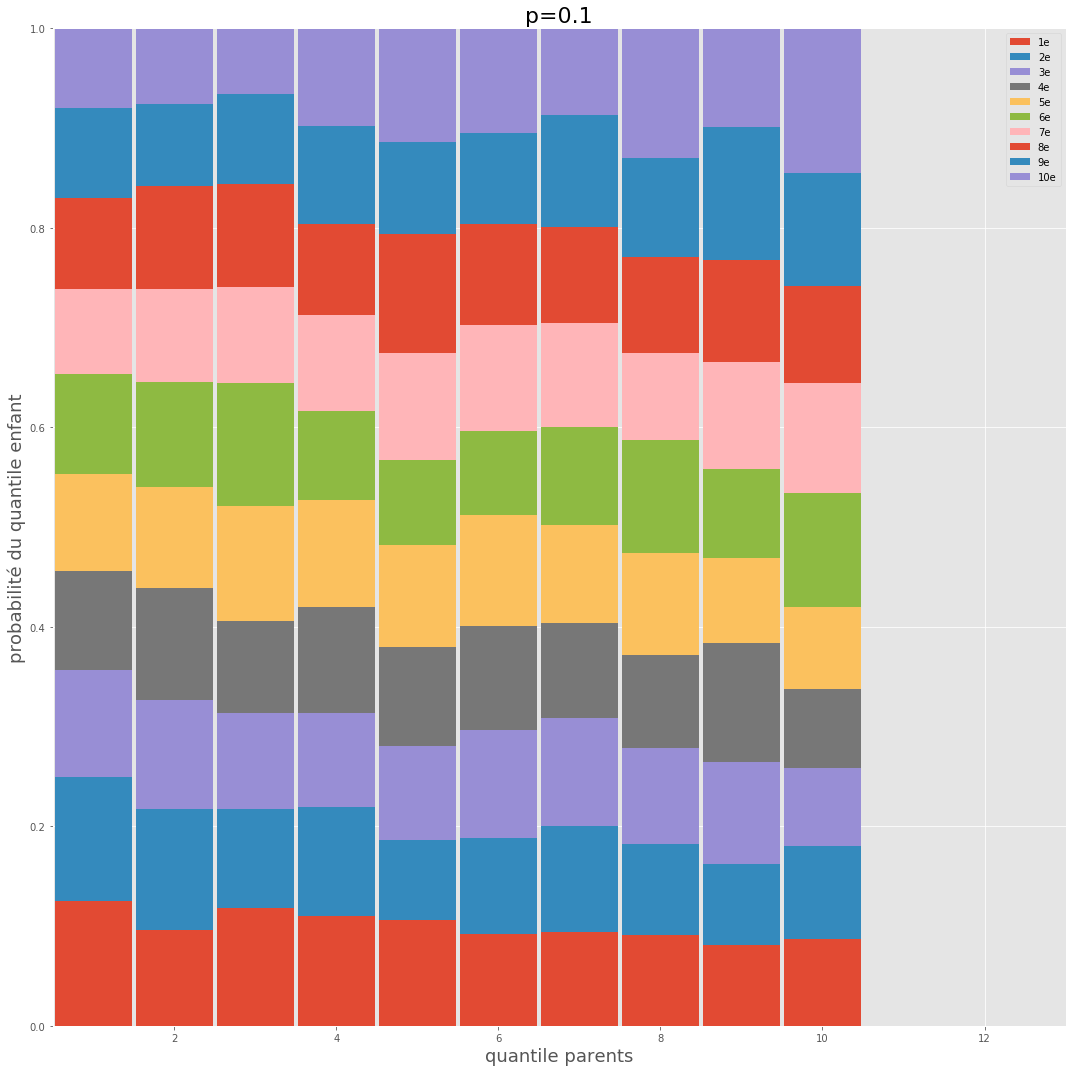

In [113]:
# Graphique pour une forte mobilité
plt.figure(figsize=(15,15))
cumul1 = np.array([0] * nb_quantiles)
for i, child_quantile in enumerate(cd1):
    plt.bar(np.arange(nb_quantiles) + 1, child_quantile, bottom=cumul1, width=0.95, label = str(i+1) + 'e')
    cumul1 = cumul1 + np.array(child_quantile)
    
plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
plt.title('p=' + str(pj1), fontsize=22)
plt.legend()
plt.xlabel('quantile parents', fontsize=18)
plt.ylabel('probabilité du quantile enfant', fontsize=18)
plt.tight_layout()

plt.savefig('graphiques/exemple_forte_mobilite_intergenerationnelle.png')
plt.show()

In [114]:
# Sachant que la classe de revenus d'un enfant est 1 et Coef Elas est 0.1 (forte mobilité)
# Alors la probabilité que la classe de revenus du parent soit 1 est:
c_i_child1 = 0
c_i_parent1 = 0
p1 = cd1[c_i_child1, c_i_parent1]
print('\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}'.format(c_i_parent1+1, c_i_child1+1, pj1, p1))


P(c_i_parent = 1 | c_i_child = 1, pj = 0.1) = 0.125


In [115]:
# Sachant que la classe de revenus d'un enfant est 1 et Coef Elas est 0.1 (forte mobilité)
# Alors la probabilité que la classe de revenus du parent soit 10 est:
c_i_child1 = 0
c_i_parent1 = 9
p1 = cd1[c_i_child1, c_i_parent1]
print('\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}'.format(c_i_parent1+1, c_i_child1+1, pj1, p1))


P(c_i_parent = 10 | c_i_child = 1, pj = 0.1) = 0.087


### Application du protocole sur nos données

[Haut de page](#sommaire)

In [116]:
# Clonage des lignes 
ready_db1 = pd.concat([ready_db] * 500)
ready_db1.sort_values(by=['Pays', 'quantile'], inplace=True)

In [117]:
ready_db1.shape

(5800000, 11)

In [118]:
ready_db1.head(3)

,Pays,quantile,income,gdpppp,ISO3,Population,Gini,region,incgroup4,Group,Coef Elas
0,Albania,1,728.89795,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
0,Albania,1,728.89795,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874
0,Albania,1,728.89795,7297.0,ALB,2947314.0,0.32141,Europe & Central Asia,Upper middle income,"Europe & Central Asia, Upper middle income",0.815874


In [119]:
# Mise en forme 
ready_db1.rename(columns={'quantile': 'c_i_child', 'income': 'y_child', 'Gini': 'Gj', 'Coef Elas': 'pj'}, inplace=True)
ready_db1 = ready_db1[['Pays', 'c_i_child', 'y_child', 'Gj', 'pj']]

ready_db1.head(3)

,Pays,c_i_child,y_child,Gj,pj
0,Albania,1,728.89795,0.32141,0.815874
0,Albania,1,728.89795,0.32141,0.815874
0,Albania,1,728.89795,0.32141,0.815874


In [120]:
import random
# Nombre de d'individus générés aléatoirement 1_000 * nb_quantiles
n=100_000

# Préparation des données
nb_quantiles=100
key3 = ready_db1['Pays'].drop_duplicates().values
c_i_parent = []
ready_db1['c_i_parent'] = 0

# Pour chaque pays
for pays in key3:
    # Selection du pays
    y_child, y_parent = generate_incomes(n, ready_db1.loc[ready_db1['Pays'] == pays, 'pj'].iloc[0]) 
    # Création des quantiles
    sample = compute_quantiles(y_child, y_parent, nb_quantiles) 
    # Création de l'arrondi du nombre d'individus attendu en fonction des distributions conditionnelles
    cd = np.round(conditional_distributions(sample, nb_quantiles) * 500)
    # Typage en entier
    cd = np.array(cd, int)
    # Passage en dataframe
    cdd = pd.DataFrame(cd)
    # Création de la transposée
    cdt = cdd.T
    # Pour chaque c_i_child
    for cic in np.arange(100):
        # Création d'une liste d'index des valeurs supérieur à 5 grâce à la transposée
        list_random = cdt.loc[cdt[cic] > 5, cic].index.tolist()

        # Si la somme des individus par pays et c_i_child est inférieure à 500 individus
        if cdd.loc[cdd.index == cic].sum().sum() < 500:        
            # Calcul du nombre de valeurs manquantes
            diff = 500 - cdd.loc[cdd.index == cic].sum().sum()
            # Prélèvement d'index dans la liste des valeurs supérieures à 5 individus
            al_ind = random.sample(list_random, diff)
            # Ajout de 1 pour les individus prélévés
            cdd.loc[cdd.index == cic, al_ind] = cdd.loc[cdd.index == cic, al_ind] + 1

        # Si la somme des individus par pays et c_i_child est supérieure à 500 individus
        elif cdd.loc[cdd.index == cic].sum().sum() > 500:
            # Calcul du nombre de valeurs en trop
            diff = cdd.loc[cdd.index == cic].sum().sum() - 500
            # Prélèvement d'index dans la liste des valeurs supérieures à 5 individus
            al_ind = random.sample(list_random, diff)
            # Soustraction de 1 pour les individus prélévés
            cdd.loc[cdd.index == cic, al_ind] = cdd.loc[cdd.index == cic, al_ind] - 1

        # Pour chaque c_i_parent
        for cip in range(0,100):
            # On étend la liste c_i_parent de l'index + 1 de la valeur contenu en c_i_child, c_i_parent
            c_i_parent.extend(np.repeat(cip + 1, cdd.iloc[cic, cip], axis=0))
    # On affecte les valeurs de la liste c_i_parent à la colonne c_i_parent de notre dataframe principale
    ready_db1.loc[(ready_db1['Pays'] == pays), 'c_i_parent'] = c_i_parent
    # On reinitialise la liste c_i_parent
    c_i_parent =[]

In [121]:
ready_db1.tail()

,Pays,c_i_child,y_child,Gj,pj,c_i_parent
11499,Yemen,100,9050.4375,0.390259,0.916461,100
11499,Yemen,100,9050.4375,0.390259,0.916461,100
11499,Yemen,100,9050.4375,0.390259,0.916461,100
11499,Yemen,100,9050.4375,0.390259,0.916461,100
11499,Yemen,100,9050.4375,0.390259,0.916461,100


In [122]:
# Suppression de la variable c_i_child inutile pour la mission 4
ready_db1.drop(columns='c_i_child', inplace=True)

In [123]:
# Création d'un dataframe avec la variable revenu moyen du pays
y_child_moy_df = ready_db1.groupby(by='Pays').mean()
y_child_moy_df.reset_index(inplace=True)
y_child_moy_df = y_child_moy_df[['Pays', 'y_child']]
y_child_moy_df.rename(columns={'y_child': 'mj'}, inplace=True)

y_child_moy_df.head(3)

,Pays,mj
0,Albania,2994.829902
1,Argentina,5847.884654
2,Armenia,1628.382785


In [124]:
# Ajout de la colonne y_child_moy
ready_db2 = pd.merge(ready_db1, y_child_moy_df, on='Pays')
ready_db2.head(3)

,Pays,y_child,Gj,pj,c_i_parent,mj
0,Albania,728.89795,0.32141,0.815874,1,2994.829902
1,Albania,728.89795,0.32141,0.815874,1,2994.829902
2,Albania,728.89795,0.32141,0.815874,1,2994.829902


In [125]:
# Ajout des colonnes 'logarithmes'
ready_db2['ln_y_child'] = np.log(ready_db2['y_child'])
ready_db2['ln_mj'] = np.log(ready_db2['mj'])

ready_db2.tail(3)

,Pays,y_child,Gj,pj,c_i_parent,mj,ln_y_child,ln_mj
5799997,Yemen,9050.4375,0.390259,0.916461,100,1042.63587,9.110568,6.949507
5799998,Yemen,9050.4375,0.390259,0.916461,100,1042.63587,9.110568,6.949507
5799999,Yemen,9050.4375,0.390259,0.916461,100,1042.63587,9.110568,6.949507


In [126]:
ready_db2.groupby('Pays').count().shape

(116, 7)

In [127]:
# Enregistrement du fichier
ready_db2.to_csv('data/analyse.csv', index=False)

[Haut de page](#sommaire)